In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import math
import pickle
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML
from matplotlib import animation
from matplotlib.collections import LineCollection
import matplotlib.patches as mpatches
import time
import os

In [2]:
# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.set_default_dtype(torch.float32)
print("Running on:", device)

Running on: cpu


In [ ]:
def wind_process(T, theta, mu, wind_sigma, n, tau):
    num_to_sim = int(T / tau)
    winds = torch.zeros(n, num_to_sim + 1, device = device)
    winds[:, 0] = 0.5 * torch.rand(n , device = device) - 0.25 
    for step in range(1, num_to_sim + 1):
        dW = torch.randn(n , device = device)
        winds[:, step] = winds[:, step - 1] +(mu - winds[:, step - 1]) * theta * tau + wind_sigma * torch.sqrt(tau) * dW
    # only return winds for the integer time-steps
    final_wind = winds[:, 1:][:, ::int(1 / tau)]
    # add initial wind to the front
    winds = torch.cat((winds[:, 0].view(n, 1), final_wind), dim = 1)
    return winds

In [4]:
def running_cost(x, y, A, M):
    return( 1 - 1/(1 + torch.exp(A * (1 - x**2 - y**2)))) * M

def terminal_cost(x, y, L_x):
    return torch.norm(x - L_x, dim = 1, keepdim = True)**2 + torch.norm(y, dim = 1, keepdim = True)**2

def regularising(th1, th2, p, r):
    full_th = torch.cat((th1, th2))
    nrm = torch.norm(full_th)
    return nrm**p + 1e-9 * torch.exp(nrm)

def regularising_t(theta1, theta2, p, beta):
    theta_vmap = torch.vmap(regularising, in_dims=(0, 1, None, None))
    ells_by_j = theta_vmap(theta1, theta2, p, theta1.shape[0])
    return torch.sum(ells_by_j) / (2 * beta**2)

def gen_ref_path(reference_control, p0, winds, vs, T, n):
    ref_path = torch.zeros(n, T+1, 2, device = device) # use a 3D tensor to store path information
    ref_path[:, 0, :] = p0 
    for t in range(T): 
        heading = torch.cat([torch.cos(reference_control), torch.sin(reference_control)], dim = 1)
        wind_vec = torch.cat([torch.zeros(n, device = device).view(n, 1), winds[:, t].view(n, 1)], dim = 1)
        ref_path[:, t+1, :] = ref_path[:, t] + vs * heading + wind_vec
    return ref_path

In [5]:
class NeuralNet_erm(nn.Module):
    def __init__(self, input_dim, width, output_dim):
        super(NeuralNet_erm, self).__init__()
        self.hidden_layer = nn.Linear(input_dim, width)
        self.hidden_layer_2 = nn.Linear(width, width)
        self.hidden_layer_3 = nn.Linear(width, width)
        self.hidden_layer_4 = nn.Linear(width, width)
        self.sigmoid = nn.Tanh()
        self.output_layer = nn.Linear(width, output_dim)
        
    def forward(self, x):
        activations_1 = self.sigmoid(self.hidden_layer(x))
        activations_2 = self.sigmoid(self.hidden_layer_2(activations_1))
        activations_3 = self.sigmoid(self.hidden_layer_3(activations_2))
        activations_4 = self.sigmoid(self.hidden_layer_4(activations_3))
        unscaled = self.output_layer(activations_4)
        return unscaled

class NeuralNet_entropy(nn.Module):
    def __init__(self, input_dim, width, output_dim):
        super(NeuralNet_entropy, self).__init__()
        self.hidden_layer = nn.Linear(input_dim, width)
        self.hidden_layer.bias.data.zero_()
        self.hidden_layer.bias.requires_grad = False
        self.sigmoid = nn.Tanh()
        self.output_layer = nn.Linear(width, output_dim)
        self.output_layer.bias.data.zero_()
        self.output_layer.bias.requires_grad = False
        self.width = width
    def forward(self, x):
        activations = self.sigmoid(self.hidden_layer(x))
        unscaled = self.output_layer(activations)
        return unscaled/self.width

In [12]:
with open("./erm_vs_entropy/2025-09-25_sim1_of_3.pt", "rb") as f:
    data = torch.load(f, map_location = device)

In [17]:
data["erm"]

{'date': '2025-09-24',
 'n': 16,
 'T': 50,
 'L_x': 20,
 'theta': 0.1,
 'mu': 0,
 'wind_sigma': 0.05,
 'tau': tensor(1),
 'A': 2,
 'M': 10,
 'activation_function': 'tanh',
 'network_width': 200,
 'start_rate': 1e-05,
 'final_rate': 1e-09,
 'num_epochs': 30000,
 'optimiser': 'AdamW',
 'scheduler': 'CosineAnnealingLR',
 'vs': 0.8,
 'training_data': tensor([[-5.8152e-02, -4.1431e-02, -1.0084e-01, -4.5754e-02, -7.1404e-02,
          -5.9451e-02,  8.5018e-03,  1.6038e-02,  7.7763e-02,  1.0567e-01,
           3.6877e-02,  6.7733e-02,  1.7758e-01,  2.0936e-01,  1.5825e-01,
           1.5802e-01,  2.1323e-01,  2.2374e-01,  2.8220e-01,  3.3638e-01,
           2.9186e-01,  3.2258e-01,  3.2475e-01,  2.2499e-01,  1.4482e-01,
           1.8154e-01,  1.2066e-01,  2.7662e-02,  8.3955e-02,  1.2486e-01,
           1.1931e-01,  1.7359e-01,  1.2741e-01,  1.4463e-01,  1.1504e-01,
           1.4293e-01,  8.8629e-02,  9.7614e-02,  1.1708e-01,  1.4191e-01,
           1.2904e-01,  5.4599e-02,  1.8042e-02, -1.4

In [46]:
# collect hyperparameters
n = data["erm"]["n"]
T = data["erm"]["T"]
tau = data["erm"]["tau"]
L_x = data["erm"]["L_x"]
theta = data["erm"]["theta"]
mu = data["erm"]["mu"]
wind_sigma = data["erm"]["wind_sigma"]
A = data["erm"]["A"]
M = data["erm"]["M"]
erm_width = data["erm"]["network_width"]
entropy_width = data["entropy_regularised"]["network_width"]
vs = data["erm"]["vs"]
training_winds = data["erm"]["training_data"]

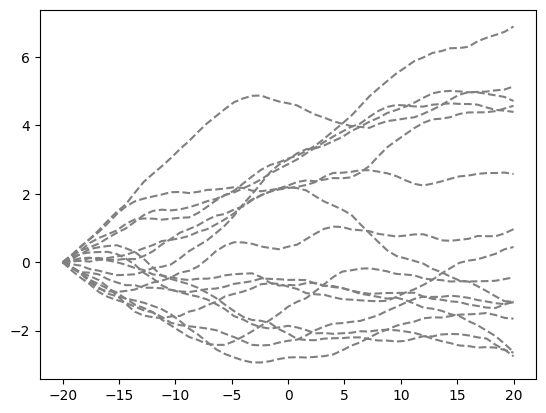

In [31]:
# generate reference trajectories
ref_ctrl = torch.zeros(n, 1, device = device)
initial_points = torch.zeros(n, 2, device = device) - torch.tensor([20, 0], device = device)
ref_path = gen_ref_path(ref_ctrl, initial_points, training_winds, vs, T, n)

for r in range(n):
    plt.plot(ref_path[r, :, 0].cpu(), ref_path[r, :, 1].cpu(), color = "gray", linestyle = "--")

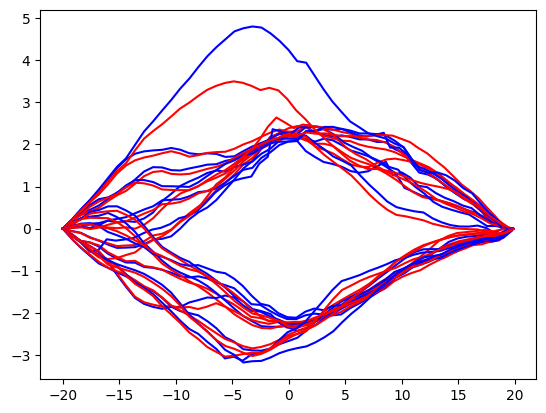

In [58]:
# generate the realised paths
# erm 
# data["erm"]["erm_model_parameters"][0].keys()
erm_params = [params for params in data["erm"]["erm_model_parameters"]]
erm_models = [NeuralNet_erm(3, erm_width, 1).to(device) for _ in range(T)]
for model, state in zip(erm_models, erm_params):
    model.load_state_dict(state)
    model.to(device)
# entropy-regularised
entropy_params = [params for params in data["entropy_regularised"]["entropy_model_parameters"]]
reg_models = [NeuralNet_entropy(4, entropy_width, 1).to(device) for _ in range(T)]
for model, state in zip(reg_models, entropy_params):
    model.load_state_dict(state)
    model.to(device)

train_paths_erm = [initial_points]
train_paths_reg = [initial_points]

# first for erm
for t in range(T):
    angle = erm_models[t](torch.cat([train_paths_erm[-1]/torch.tensor([20, 10], device = device),
                                     training_winds[:, t].view(n, 1)], dim = 1))
    heading = torch.cat([torch.cos(angle), torch.sin(angle)], dim = 1)
    wind_vec = torch.cat([torch.zeros(n, 1, device = device), training_winds[:, t].view(n, 1)], dim = 1)
    new_p = train_paths_erm[-1] + vs* heading + wind_vec
    train_paths_erm.append(new_p)
train_paths_erm = torch.stack(train_paths_erm, dim = 1)

# then for entropy-regularised
for t in range(T):
    angle = reg_models[t](torch.cat([train_paths_reg[-1]/torch.tensor([20, 10], device = device),
                                     training_winds[:, t].view(n, 1),
                                     torch.ones(n, 1, device = device)], dim = 1))
    heading = torch.cat([torch.cos(angle), torch.sin(angle)], dim = 1)
    wind_vec = torch.cat([torch.zeros(n, 1, device = device), training_winds[:, t].view(n ,1)], dim = 1)
    new_p = train_paths_reg[-1] + vs * heading + wind_vec
    train_paths_reg.append(new_p)
train_paths_reg = torch.stack(train_paths_reg, dim = 1)

for pth in range(n):
    plt.plot(train_paths_erm[pth, :, 0].detach().cpu(), train_paths_erm[pth, :, 1].detach().cpu(), color = "blue")
    plt.plot(train_paths_reg[pth, :, 0].detach().cpu(), train_paths_reg[pth, :, 1].detach().cpu(), color = "red")

In [ ]:
# generate test winds
test_size = 1000
test_winds = wind_process(T, theta, mu, wind_sigma, test_size, tau)

# generate test trajectories

# erm

# entropy-regularised


dict_keys(['erm', 'entropy_regularised'])

In [21]:
# generate test trajectories

In [22]:
# plot in-sample vs out-of-sample for both methods

In [23]:
# same but histograms

In [24]:
# generate the animations